In [48]:
#Importamos las librerias que usaremos
from pypfopt.efficient_frontier import EfficientFrontier #pypfopt es la libreria de optimizacion de portafolios, es la libreria especifica para modelos financieros, acá estamos importando la frontera eficiente
from pypfopt import risk_models #modelos de riesgo
from pypfopt import expected_returns #retornos esperados
from matplotlib.ticker import FuncFormatter
import pandas as pd #PANDAS ES PARA MANIPULAR LOS DATOS
import pandas_datareader as pdr
import numpy as np  #NUMPY ES PARA HACER CALCULO ENTRE MATRICES
import matplotlib   #PARA GRAFICAR
import matplotlib.pyplot as plt 
from scipy import stats  #PARA SACAR LAS ESTADISTICAS, R2, PRUEBAS, ETC.
import seaborn as sns; sns.set() #PARA CREAR PLOTS
import warnings  #PARA CONTROLAR LAS ADVERTENCIAS
import itertools #ES PARA HACER FUNCIONES ITERABLES
import datetime

In [49]:
#Armamos el portafolio
acciones = ["GOOGL", "FB", "AAPL", "NFLX", "AMZN"]
thelen = len (acciones) 
price_data = []
for ticker in range(thelen):
    prices = pdr.DataReader(acciones[ticker], start="2018-01-01", end = datetime.date.today(), data_source="yahoo")
    price_data.append(prices[["Close"]])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns= acciones
df_stocks.tail()

,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2020-08-13,1516.650024,261.299988,460.040009,481.329987,3161.020020
2020-08-14,1504.630005,261.239990,459.630005,482.679993,3148.020020
2020-08-17,1516.239990,261.160004,458.429993,482.350006,3182.409912
2020-08-18,1555.780029,262.339996,462.250000,491.869995,3312.489990
2020-08-19,1544.609985,262.589996,462.829987,484.529999,3260.479980


In [51]:
#Para el siguiente paso, calcularemos los pesos de cartera de cada activo. 
#Retornos Anualizados
mu = expected_returns.mean_historical_return(df_stocks)
#Varianza de la cartera
Sigma = risk_models.sample_cov(df_stocks)
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #Los límites de peso en negativo permiten el cortocircuito de las acciones
sharpe_pfolio=ef.max_sharpe() 
#Puede usar agregar objetivo para asegurar una ponderación mínima cero para acciones individuales
sharpe_pwt=ef.clean_weights()
sharpe_pwt

OrderedDict([('GOOGL', 0.0),
             ('FB', 0.0),
             ('AAPL', 0.42508),
             ('NFLX', 0.04126),
             ('AMZN', 0.53365)])

In [52]:
#Las ponderaciones de los activos se utilizarán para calcular el rendimiento esperado de la cartera.
# Cálculo de VaR
ticker_rx2 = []

In [53]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

In [54]:
#Ahora, convertiremos los precios de las acciones de la cartera en un rendimiento acumulativo, que también puede considerarse como los rendimientos del período de tenencia (HPR) para este proyecto.
for a in range(thelen):
  ticker_rx = df_stocks[[acciones[a]]].pct_change()
  ticker_rx = (ticker_rx+1).cumprod()
  ticker_rx2.append(ticker_rx[[acciones[a]]])
ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final

,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.017061,1.017914,0.999826,1.019794,1.012775
2018-01-04,1.021012,1.016040,1.004470,1.022679,1.017308
2018-01-05,1.034551,1.029931,1.015906,1.044363,1.033751
2018-01-08,1.038203,1.037813,1.012133,1.054608,1.048662
...,...,...,...,...,...
2020-08-13,1.413190,1.440304,2.670614,2.393843,2.658531
2020-08-14,1.401990,1.439974,2.668234,2.400557,2.647598
2020-08-17,1.412808,1.439533,2.661268,2.398916,2.676521


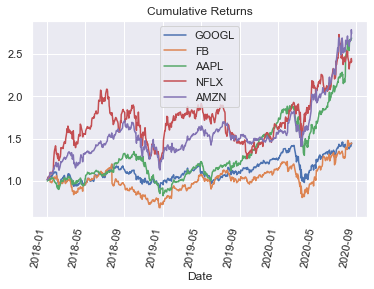

In [55]:
for i, col in enumerate(ticker_final.columns):
  ticker_final[col].plot()
plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(ticker_final.columns)
#Guardamos el Plot en un JGP
plt.savefig('CR.png', bbox_inches='tight')

In [68]:
#Ahora, seleccionaremos el último HPR de cada activo y multiplicaremos los retornos con los pesos de activos calculados usando la función .dot ()
# Tomando los últimos valores de rendimiento
pret = [] 
pre1 = [] 
price = []
for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stocks.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
ex_rtn=pre1.dot(sh_wt)
print('El rendimiento de cartera esperado ponderado para el período de tiempo seleccionado es:' + str (ex_rtn))
#ex_rtn = (ex_rtn)**0.5-(1) #Anualizando el rendimiento acumulado (no afectará el resultado)
price=price.dot(sh_wt) #Calculando el valor ponderado 
print(ex_rtn, varsigma,price)

El rendimiento de cartera esperado ponderado para el período de tiempo seleccionado es:[2.70490066]
[2.70490066] 0.5839516716925229 Date
2020-08-19    1956.68662
dtype: float64


In [69]:
#Ahora armaremos el MonteCarlo, tomaremos un intervalo de confianza de 95%
from scipy.stats import norm
import math
Time=1440 #Numero de dias de negociacion
lt_price=[]
final_res=[]


In [75]:
 #10000 numero de simulaciones
 for i in range(10000):
     daily_returns = (np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
     plt.plot(daily_returns)
     plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
     plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
     plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()


NameError: name 'daily_returns' is not defined

In [42]:
#vamos a ver la distribucion
plt.hist(daily_returns,bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

NameError: name 'daily_returns' is not defined

In [43]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) ##VaR - Pérdida mínima de 5,7% con una probabilidad del 5%, también una ganancia puede ser superior al 15% con una probabilidad del 5%
pvalue = 1000000 #valor del portafolio
print('La cantidad $ requerida para cubrir las pérdidas mínimas por un día es:' + str(pvalue* - np.percentile(daily_returns,5)))

NameError: name 'daily_returns' is not defined